<a href="https://colab.research.google.com/github/Kathy42xu/DL_TA/blob/main/diffusion_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introduction
In this project, we explore diffusion models, a key generative AI technique. Diffusion models iteratively refine noisy data into meaningful patterns, offering a unique way to generate high-quality outputs. They are based on two main processes:

1. Forward Diffusion (Noising): Gradually adds Gaussian noise to data over multiple steps.
2. Reverse Diffusion (Denoising): Trains a neural network to iteratively remove noise and reconstruct the original data.


This project demonstrates these concepts using a scatter plot resembling Homer Simpson as an example.

##Key Objectives:

1. Understand the forward and reverse processes.
2. Learn how hyperparameters influence the diffusion process.
3. Visualize the denoising process and evaluate the results.

#Step 1: Importing Libraries
We first import the necessary libraries for tensor computation, visualization, and neural network training.

In [ ]:
# Import required libraries
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image


Set up the computation device (GPU or CPU):

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


#Step 2: Data Preparation and Visualization
The dataset for this project is a scatter plot based on an image of Homer Simpson.

Download this image https://www.infomoney.com.br/wp-content/uploads/2019/06/homer-simpson.jpg?resize=900%2C515&quality=50&strip=all and save it in this folder as 'homer.png'


We preprocess the image by converting it to grayscale, resizing it, and extracting the coordinates of pixels below a certain intensity threshold. These coordinates form the scatter plot.

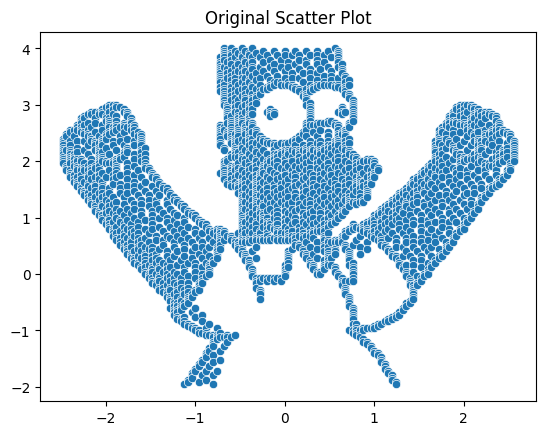

In [ ]:
# Function to scatter pixels from an image
import string
from PIL import Image

IMG_SIZE = 150
def scatter_pixels(img_file):
    """Return the URL of a scatter plot of the supplied image

    The image will be rendered square and black on white. Adapt the
    code if you want something else.
    """
    # Use simple chart encoding. To make things really simple
    # use a square image where each X or Y position corresponds
    # to a single encode value.
    w = IMG_SIZE
    img = Image.open(img_file).resize((w, w)).convert("1")
    pels = img.load()
    black_pels = [(x, y) for x in range(w) for y in range(w)
                  if pels[x, y] == 0]
    sqside = 3.0

    # invert Y coordinate with w-y
    return [t[0] for t in black_pels],[w - t[1] for t in black_pels]

# Generate scatter data from the image
x, y = scatter_pixels('homer.png')
x = [x / 25 - 3 for x in x]  # Normalize x-coordinates
y = [y / 25 - 2 for y in y]  # Normalize y-coordinates

# Visualize the original scatter plot
sns.scatterplot(x=x, y=y)
plt.title("Original Scatter Plot")
plt.show()


###Prepare data for diffusion

 transform 2D data (x and y coordinates) into a 1D vector format and vice versa


In [ ]:
def pack_data(x,y):
    """
    pack 2d data to 1d vector
    """
    one_d_data = []
    for i in range(len(x)):
        one_d_data.append(x[i])
        one_d_data.append(y[i])

    return one_d_data

def unpack_1d_data(one_d_data):
    """
    unpack 1d data to 2d vector
    """
    x = []
    y = []
    for i in range(len(one_d_data)):
        if i%2==0:
            x.append(one_d_data[i])
        else:
            y.append(one_d_data[i])
    return x,y

one_d_data = pack_data(x,y)
x_init = torch.tensor(one_d_data).to(torch.float32).to(device)

DATA_SIZE = len(x_init)

#Step 3: Diffusion Hyperparameters
### 1. Noise Addition
- The data, represented as $X_0$, is iteratively perturbed with Gaussian noise over $T$ timesteps.
- Each timestep $t$ corresponds to a noise level, determined by a predefined schedule (e.g., `list_bar_alphas` ).
- Noise is applied such that the data becomes indistinguishable from pure noise as $t \to T$.

**Formula**:

$$
q(X_t \mid X_{t-1}) =\prod_{i=1}^{n}(X_t; \sqrt{\alpha_t} X_{t-1}, \beta_t I)
$$

**Where**:
- $\alpha_t$: Scaling coefficient for data preservation.
- $\beta_t = 1 - \alpha_t$: Noise variance.

At the end of the forward process, $X_T$ is approximately pure noise.

### 2. Posterior Calculation
- For efficient training, the posterior distribution $q(X_{t-1} \mid X_t, X_0)$ is analytically derived:

$$
q(X_{t-1} \mid X_t, X_0) = \prod_{i=1}^{n}(X_{t-1}; \mu_t, \sigma_t^2 I)
$$

**Where**:
- $\mu_t$ and $\sigma_t$ depend on $\alpha_t$, $\beta_t$, and $X_0$.

---

## Reverse Process

### 1. Denoising
- The reverse process aims to invert the forward process, reconstructing $X_0$ from $X_T$.
- The model predicts the mean $\mu_\theta$ of the posterior distribution $q(X_{t-1} \mid X_t)$.
- The variance $\beta_t$ remains fixed, simplifying the learning task.

**Key Insight**:
The reverse process also assumes Gaussian transitions:

$$
p_\theta(X_{t-1} \mid X_t) = \prod_{i=1}^{n}(X_{t-1}; \mu_\theta(X_t, t), \beta_t I)
$$

### 2. Training Objective
- The model minimizes the mean squared error (MSE) between $\mu_\theta$ (predicted mean) and $\mu_t$ (true mean from the forward process):

$$
L = \mathbb{E}_{X_0, t, \epsilon} \left[ \| \mu_\theta(X_t, t) - \mu_t \|^2 \right]
$$

**Where**:
- $\epsilon \sim N(0, I)$: Gaussian noise.
- The expectation is taken over the data $X_0$, timesteps $t$, and noise $\epsilon$.

---



Hyperparameters control the noise schedule and the diffusion process:

**beta_start** and **beta_end**: Define the initial and final noise levels.

**num_diffusion_timesteps**: The number of steps in the diffusion process.

**alphas** and **list_bar_alphas**: Control the signal and noise retention.

In [ ]:
# Hyperparameters for diffusion
DATA_SIZE = len(x)  # Total number of data points
beta_start = 0.0004  # Starting noise level
beta_end = 0.02  # Ending noise level
num_diffusion_timesteps = 30  # Number of timesteps

# Compute betas and alphas
betas = np.linspace(beta_start**0.5, beta_end**0.5, num_diffusion_timesteps) ** 2
alphas = 1 - betas
list_bar_alphas = np.cumprod(alphas)  # Cumulative product of alphas

# Convert to PyTorch tensors
betas = torch.tensor(betas, dtype=torch.float32).to(device)
alphas = torch.tensor(alphas, dtype=torch.float32).to(device)
list_bar_alphas = torch.tensor(list_bar_alphas, dtype=torch.float32).to(device)


#Step 4: Implementing Diffusion Functions

##Forward Diffusion
The forward process adds Gaussian noise to the data. This is done step-by-step, with each step parameterized by the cumulative alpha product.

In [ ]:
def q_sample(x_start, t, list_bar_alphas, device):
    """
    Diffuse the data (t == 0 means diffused for 1 step)
    """
    alpha_bar_t = list_bar_alphas[t]

    mean = alpha_bar_t*x_start
    cov = torch.eye(x_start.shape[0]).to(device)
    cov = cov*(1-alpha_bar_t)
    return torch.distributions.MultivariateNormal(loc=mean,covariance_matrix=cov).sample().to(device)


##Reverse Denoising

The reverse process removes noise step-by-step to reconstruct the original data.

In [ ]:
def denoise_with_mu(denoise_model, x_t, t, list_alpha, list_alpha_bar, DATA_SIZE, device):
    """
    Denoising function considering the denoising models tries to model the posterior mean
    """
    alpha_t = list_alpha[t]
    beta_t = 1 - alpha_t
    alpha_bar_t = list_alpha_bar[t]

    mu_theta = denoise_model(x_t,t)

    x_t_before = torch.distributions.MultivariateNormal(loc=mu_theta,covariance_matrix=torch.diag(beta_t.repeat(DATA_SIZE))).sample().to(device)

    return x_t_before


In [ ]:
def posterior_q(x_start, x_t, t, list_alpha, list_alpha_bar, device):
    """
    calculate the parameters of the posterior distribution of q
    """
    beta_t = 1 - list_alpha[t]
    alpha_t = list_alpha[t]
    alpha_bar_t = list_alpha_bar[t]
    # alpha_bar_{t-1}
    alpha_bar_t_before = list_alpha_bar[t-1]

    # calculate mu_tilde
    first_term = x_start * torch.sqrt(alpha_bar_t_before) * beta_t / (1 - alpha_bar_t)
    second_term = x_t * torch.sqrt(alpha_t)*(1- alpha_bar_t_before)/ (1 - alpha_bar_t)
    mu_tilde = first_term + second_term

    return mu_tilde, None

The position_encoding_init function creates a sinusoidal positional encoding table, which is often used in transformer-based models or models that require a representation of sequential or temporal information (like diffusion models). Positional encodings inject information about the position of data points into the model.

In [ ]:
def position_encoding_init(n_position, d_pos_vec):
    """
    Initialize sinusoidal positional encodings.
    Args:
        n_position: Number of timesteps (num_diffusion_timesteps).
        d_pos_vec: Dimensionality of the positional encoding (matches len(x_init)).
    Returns:
        A PyTorch tensor of shape [n_position, d_pos_vec].
    """
    position_enc = np.array([
        [pos / np.power(10000, 2 * (i // 2) / d_pos_vec) for i in range(d_pos_vec)]
        if pos != 0 else np.zeros(d_pos_vec) for pos in range(n_position)
    ])
    position_enc[:, 0::2] = np.sin(position_enc[:, 0::2])  # Apply sine to even indices
    position_enc[:, 1::2] = np.cos(position_enc[:, 1::2])  # Apply cosine to odd indices
    return torch.tensor(position_enc, dtype=torch.float32)


#Step 5: Building the Denoising Neural Network

The neural network predicts the mean of the reverse process distribution. Positional encodings are used to incorporate timestep information.


###The neural network comprises three fully connected layers:

1. Layer 1 (linear1): Combines the input data and positional encoding using a linear transformation.
2. Layer 2 (linear2): Applies a second linear transformation after a ReLU activation.
3. Layer 3 (linear3): Produces the final output, predicting the mean of the reverse process distribution.

##Structure of Denoising

![Denoising Model Diagram](https://mermaid.ink/img/pako:eNqVk99r2zAQx_-VQ2D8MIXSDfbghUAS5xekXUm2PrQuRbbPyYEtBUnukpn875PlrHVfNuon3dff-9xZvmtYpnJkEQuChiTZCJrQ7rHCMIIwx0LUpQ05dNq90CTSEo172UBYKGm39Ntbr78ejuH5fA6CRO60OOxhvUkkuGf8mLBhOlrJQ20hFlZEcHymNhqm-mp0q8icvO7DmCqUhpRsXTlVw6t0lLAnGAxGMOlId8qQdQ6YSdc7yV0EWKWP9ulfgK6XiedMO86lC_jUpj_bd8apN8adcU0Shb72eP8Zf9Gt8L22PaXPiD1j1jE2uP4J48zSi2h7f2eceeO8X-zzR4vNPWPx_2ILb1z2i335aLGlZ6w6xsXmU-405pRZzOEGhfTSXGnY4AtqgxBTUdSm31HHCwLY2lPpfiXcumk0ULikmdwLmTnUPRlKqSR7gna62oSsFMbEWEAp9A5_4NFCO4wD46YxakeRd_EvpN3eRqkq82-9TBjzCZ_ymM_4nC_4kq_eQM7HOKtQV4JytxdNm5cwP_8Ji9zxshUJS-TZWUVt1fYkMxZZXSNnWtW7PYsKURoX1YdcWIxJuKWoXtWDkA9KvcXu1qzSN90m-oU8_wH2PyeR?type=png)


##Working Principle of the Denoising Model
###Core Objective
The primary goal of the Denoising model is to predict the mean of clean data from noisy input data at each timestep in the diffusion process. The detailed workflow is as follows:

###Background of the Diffusion Process
Diffusion models work by progressively adding noise to the data, creating a series of increasingly noisy intermediate states. The objective is to reverse this process: starting from pure noise, the model gradually removes the noise to recover the original, clean data.

###Introduction of Timesteps
Each timestep t represents a distinct stage in the diffusion process. The position encoding emb[t] transforms the timestep information into an embedding vector with the same dimensionality as the data. This allows the model to adjust its denoising strategy based on the current level of noise.

##Denoising Process
Input Fusion:

Operation: The noisy input data x_input is added to the position encoding emb[t].
Purpose: This fusion incorporates the timestep information into the input data, providing context that informs the denoising process.


Feature Extraction and Transformation:

Mechanism: The combined input passes through multiple fully connected (linear) layers interspersed with ReLU activation functions.
Function: These layers progressively extract and transform the data's features, capturing complex patterns and relationships within the data.


Mean Prediction:

Operation: The final fully connected layer outputs a prediction of the mean.
Purpose: This predicted mean is used in the reverse diffusion process to guide the denoising steps, helping to restore a clearer signal from the noisy input.
##Reverse Diffusion Process
In the reverse diffusion process, the model utilizes the predicted mean to incrementally reduce the noise present in the data. Through each subsequent timestep, the noise is diminished, ultimately resulting in a clear and accurate reconstruction of the original data.

In [ ]:
class Denoising(torch.nn.Module):
    def __init__(self, x_dim, num_timesteps):
        """
        Initialize the denoising model.
        Args:
            x_dim: Dimensionality of input data (matches len(x_init)).
            num_timesteps: Number of timesteps in the diffusion process.
        """
        super(Denoising, self).__init__()
        self.linear1 = torch.nn.Linear(x_dim, x_dim)
        self.emb = position_encoding_init(num_timesteps, x_dim)  # Match len(x_init)
        self.linear2 = torch.nn.Linear(x_dim, x_dim)
        self.linear3 = torch.nn.Linear(x_dim, x_dim)
        self.relu = torch.nn.ReLU()

    def forward(self, x_input, t):
        """
        Forward pass for the denoising model.
        Args:
            x_input: Noisy input data (size matches len(x_init)).
            t: Current timestep.
        Returns:
            Predicted mean for the reverse process.
        """
        emb_t = self.emb[t]
        if x_input.shape != emb_t.shape:  # Ensure shapes match
            raise ValueError(f"Shape mismatch: x_input {x_input.shape}, emb_t {emb_t.shape}")
        x = self.relu(self.linear1(x_input + emb_t))
        x = self.relu(self.linear2(x))
        return self.linear3(x)



The network uses the ReLU (Rectified Linear Unit) activation function after the first two layers. ReLU introduces non-linearity, enabling the network to model complex relationships in the data.

The network outputs the predicted mean of the reverse Gaussian distribution for the given timestep. This predicted mean guides the denoising process.

#Step 6: Training the Model


During training, the model is provided with noisy data at random timesteps and is tasked to predict the mean of the reverse distribution. The loss function measures the difference between the model’s predictions and the true means, and the optimizer updates the model parameters to minimize this error. Over multiple epochs, the model learns how to effectively denoise the data, enabling it to reconstruct meaningful data from pure noise. This process is foundational to generative applications like generating images or reconstructing data from noise.

In this module, the optimizer used is AdamW, which is a variant of the Adam optimizer that includes weight decay to help regularize the model and prevent overfitting. It adjusts the parameters of the denoising model during training to minimize the error.

The error is measured using the Mean Squared Error (MSE) loss, implemented as nn.MSELoss(). This loss function calculates the squared difference between the predicted mean from the model and the true mean derived from the posterior of the forward diffusion process. By minimizing this error, the model learns to predict the denoised data more accurately at each timestep.

[![](https://mermaid.ink/img/pako:eNplkM1qwzAQhF9l0aGn5AV8KKRNaH7sUhp6qZTDIm1sUf0hS5QQ8u6VVZMeetvZ-Rh258qkV8Qa1kcMA7TvwgHAih8TxnSC5fIRtvyFHEVMBK9ejxdYY8JT5WBbiR1_i6S0TNAROvjWaYCuxJqZ2lVqz5_RyGymoNaP42zuq3ngTyi_QvQB-wl4gI-gyjBDhwq1fCVltv8i2up2fOMUbIKXQ9mzBbMULWpVnrtOnGBpIEuCNWVUdMZskmDC3QqKOfnjxUnWnNGMtGDR5364q1xvWWssLdn7NqD79P5PlwqSj91vn7XW2w-DynCO?type=png)](https://mermaid.live/edit#pako:eNplkM1qwzAQhF9l0aGn5AV8KKRNaH7sUhp6qZTDIm1sUf0hS5QQ8u6VVZMeetvZ-Rh258qkV8Qa1kcMA7TvwgHAih8TxnSC5fIRtvyFHEVMBK9ejxdYY8JT5WBbiR1_i6S0TNAROvjWaYCuxJqZ2lVqz5_RyGymoNaP42zuq3ngTyi_QvQB-wl4gI-gyjBDhwq1fCVltv8i2up2fOMUbIKXQ9mzBbMULWpVnrtOnGBpIEuCNWVUdMZskmDC3QqKOfnjxUnWnNGMtGDR5364q1xvWWssLdn7NqD79P5PlwqSj91vn7XW2w-DynCO)

In [ ]:
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm  # Import tqdm for progress bar
import numpy as np
import torch


training_steps_per_epoch = 40  # Number of training steps per epoch

# Loss function: Mean Squared Error (MSE) for regression tasks
criterion = nn.MSELoss()

# Initialize the denoising model (assuming Denoising class is defined elsewhere)
denoising_model = Denoising(len(x_init), num_diffusion_timesteps).to(device)

# Optimizer: AdamW with a learning rate of 1e-3
optimizer = optim.AdamW(denoising_model.parameters(), lr=1e-3)

# Training loop with progress bar
pbar = tqdm(range(10))
for epoch in pbar:
    running_loss = 0.0  # Accumulate loss over the epoch

    # Randomly sample timesteps for diffusion process
    Ts = np.random.randint(1, num_diffusion_timesteps, size=training_steps_per_epoch)

    for _, t in enumerate(Ts):
        t_tensor = torch.tensor(t, dtype=torch.long)  # Convert timestep to tensor

        # Generate noisy data using the forward diffusion process
        q_t = q_sample(x_init, t_tensor, list_bar_alphas, device)

        # Retrieve positional encoding for the current timestep
        #emb_t = denoising_model.emb[t_tensor]

        # Compute posterior mean (target) and predicted mean
        mu_t, _ = posterior_q(x_init, q_t, t_tensor, alphas, list_bar_alphas, device)
        mu_theta = denoising_model(q_t, t_tensor)

        # Calculate loss between predicted and target means
        loss = criterion(mu_theta, mu_t)

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Update progress bar with average loss for the epoch
    pbar.set_description(f'Epoch: {epoch + 1}, Loss: {running_loss / training_steps_per_epoch}')

Epoch: 10, Loss: 0.054593140608631074: 100%|██████████| 10/10 [35:01<00:00, 210.16s/it]


#Step 7: Inference
This section demonstrates the reverse diffusion process, starting from random noise and reconstructing a denoised version of the data, followed by visualizing it as a scatter plot. The steps are outlined below:

##Initialize Random Noise:

A multivariate normal distribution is used to generate a random noise vector with the same dimensionality as the input data (x_init).
The noise has a mean of zero (loc) and an identity covariance matrix (covariance_matrix), ensuring it is isotropic.

##Reverse Diffusion Process:

The reverse diffusion iteratively denoises the data over a series of timesteps (num_diffusion_timesteps).
Starting from the most noisy state (last timestep), the denoise_with_mu function is applied at each step to estimate the previous timestep's state using the learned denoising model (denoising_model) and precomputed diffusion parameters (alphas, list_bar_alphas).
This gradually refines the data, moving it closer to the original data distribution.

##Convert and Unpack Data:

Once the reverse diffusion process is complete, the denoised data is moved to the CPU and converted to a NumPy array for compatibility with plotting tools.
The 1D vector of denoised data is then unpacked into two separate arrays (x_new and y_new) representing the x and y coordinates.
Visualize Reconstructed Data:

The reconstructed x and y coordinates are used to create a scatter plot.
Labels for the axes and a title are added for clarity, providing a visual comparison of the reconstructed data against the original scatter plot.


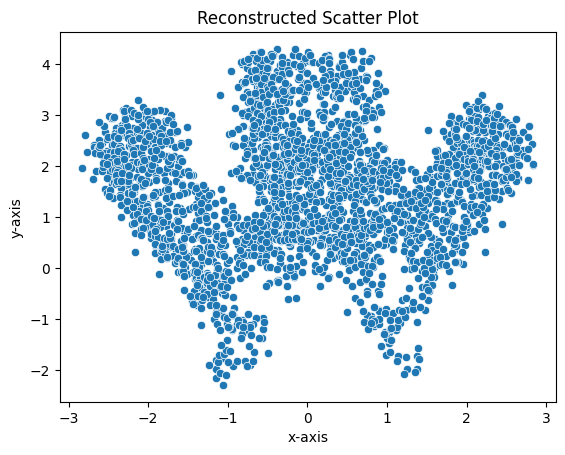

In [ ]:
# Start with random noise
data = torch.distributions.MultivariateNormal(
    loc=torch.zeros(len(x_init)),  # Size matches x_init
    covariance_matrix=torch.eye(len(x_init))
).sample().to(device)

# Apply reverse diffusion process
for t in reversed(range(num_diffusion_timesteps)):
    data = denoise_with_mu(denoising_model, data, t, alphas, list_bar_alphas, len(x_init), device)

# Unpack the denoised data into x and y coordinates
data_np = data.cpu().detach().numpy()  # Move data to CPU and convert to NumPy
x_new, y_new = unpack_1d_data(data_np)  # Unpack the 1D data into 2D (x, y)

# Convert to NumPy arrays for compatibility with plotting
x_new = np.array(x_new, dtype=float)
y_new = np.array(y_new, dtype=float)

# Plot the reconstructed scatter plot
sns.scatterplot(x=x_new, y=y_new)
plt.title("Reconstructed Scatter Plot")
plt.xlabel("x-axis")
plt.ylabel("y-axis")
plt.show()


#Step 8: Animation of the Diffusion Process
To better understand the reverse diffusion process, we create an animation that visualizes the stepwise denoising.

In [ ]:
!pip install celluloid

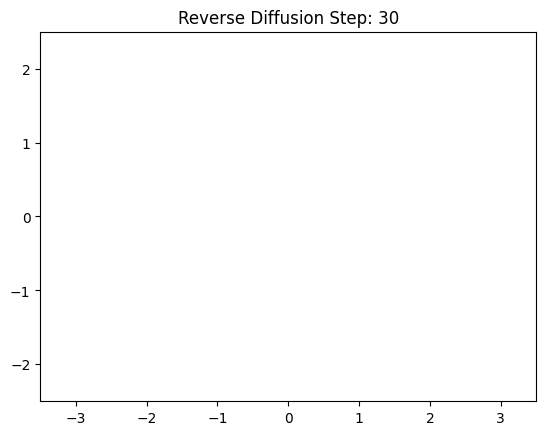

In [ ]:
import numpy as np
from celluloid import Camera
import seaborn as sns
import matplotlib.pyplot as plt

# Create a figure for the animation
fig = plt.figure()
camera = Camera(fig)

# Set consistent x and y axis limits based on the original scatter plot
x_limits = (-3.5, 3.5)  # Adjust based on the normalized data range
y_limits = (-2.5, 2.5)

# Reverse diffusion process and capture each timestep
for d in range(1, num_diffusion_timesteps + 1):
    # Perform reverse diffusion step
    data = denoise_with_mu(denoising_model, data, num_diffusion_timesteps - d, alphas, list_bar_alphas, len(x_init), device)

    # Extract and unpack the data into x and y coordinates
    data_plot = data.detach().cpu().numpy()
    x_new, y_new = unpack_1d_data(data_plot)

    # Plot the current state
    graph = sns.scatterplot(x=x_new, y=y_new, color='green', s=10)  # Removed `palette` and set `color`
    graph.set_xlim(x_limits)  # Maintain consistent x-axis limits
    graph.set_ylim(y_limits)  # Maintain consistent y-axis limits
    plt.title(f"Reverse Diffusion Step: {d}")
    camera.snap()

# Create the animation
anim = camera.animate(blit=False)

# Save as a GIF
anim.save('output.gif', fps=24, dpi=120)


#Final Summary

This project provided a step-by-step guide to implementing a diffusion model for generating a scatter plot resembling Homer Simpson. Through the process, we explored:
 1. Forward Diffusion: A Markov process that progressively adds Gaussian noise to the data, turning it into near-pure noise over multiple steps.
 2. Reverse Diffusion: Using a neural network, we learned to iteratively remove noise and reconstruct the original data.
 3. Key Components: **Hyperparameters**: Controlled the noise schedule and the cumulative effects of noise and signal retention. **Neural Network**: Predicted the mean of the reverse distribution at each timestep using positional encodings.